#Financial Sentiment Analysis

#1. นำเข้าและโหลดข้อมูล (Data Import)

In [ ]:
# ตั้งค่าและนำเข้าไลบรารีที่จำเป็น
import pandas as pd
import numpy as np
import re
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Import data
drive.mount('/content/drive')
# Replace 'your_file_path.csv' with the actual path to your CSV file in Google Drive
file_path = '/content/drive/My Drive/data.csv'
df = pd.read_csv(file_path)

print(df.head())


Mounted at /content/drive
                                            Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral


In [ ]:
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


DataFrame df ที่มีสองคอลัมน์: Sentence (ข้อความเกี่ยวกับการเงิน) และ Sentiment (ฉลากความรู้สึก: positive, negative, neutral)



# 2. เปลี่ยนชื่อคอลัมน์และแปลงฉลาก (Data Preprocessing)

In [ ]:
df.columns = ['tweet', 'label']
df.label = df.label.map({'positive':0, 'negative':1, 'neutral':2})
df.head()

,tweet,label
0,The GeoSolutions technology will leverage Bene...,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1
2,"For the last quarter of 2010 , Componenta 's n...",0
3,According to the Finnish-Russian Chamber of Co...,2
4,The Swedish buyout firm has sold its remaining...,2


เปลี่ยนชื่อคอลัมน์จาก Sentence เป็น tweet และ Sentiment เป็น label เพื่อให้สอดคล้องกับบริบทการวิเคราะห์ (เช่น การวิเคราะห์ทวีต)
แปลงฉลากความรู้สึกจากข้อความ (positive, negative, neutral) เป็นตัวเลข:
* positive → 0
* negative → 1
* neutral → 2


In [ ]:
df.shape

(5842, 2)

In [ ]:
df.isnull().sum()

,0
tweet,0
label,0


In [ ]:
df.describe()

,label
count,5842.000000
mean,1.218761
std,0.897258
min,0.000000
25%,0.000000
50%,2.000000
75%,2.000000
max,2.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   5842 non-null   object
 1   label   5842 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.4+ KB


In [ ]:
# check unique categories
df['label'].value_counts()

,count
label,
2,3130
0,1852
1,860


#Data Cleaning

In [ ]:
#ทำความสะอาดข้อความ
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # ลบอักขระพิเศษและตัวเลข
    text = text.lower()  # แปลงเป็นตัวพิมพ์เล็ก
    text = ' '.join([word for word in text.split() if word not in stop_words])  # ลบ stop words
    return text

# ทำความสะอาดข้อมูล
df['tweet'] = df['tweet'].apply(clean_text)

ใช้ฟังก์ชัน clean_text เพื่อ:
ลบอักขระพิเศษและตัวเลข
แปลงเป็นตัวพิมพ์เล็ก
ลบ stop words ด้วย nltk

# 3.Modeling

In [ ]:
# data split
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(df['tweet'], df['label'], test_size = 0.4, random_state = 92)

การแบ่งข้อมูลและ Feature Extraction (60% train, 40% test)
ใช้ TfidfVectorizer แทน CountVectorizer เพื่อให้ได้ฟีเจอร์ที่คำนึงถึงความสำคัญของคำ (จำกัดคำศัพท์ที่ 5000 คำเพื่อลด noise)

In [ ]:
# แปลงข้อความเป็น TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # จำกัดคำศัพท์ 5000 คำเพื่อลด noise
xtrain_tfidf = vectorizer.fit_transform(xtrain).toarray()
xtest_tfidf = vectorizer.transform(xtest).toarray()

In [ ]:
# จัดการ class imbalance ด้วย SMOTE
smote = SMOTE(random_state=42)
xtrain_tfidf_res, ytrain_res = smote.fit_resample(xtrain_tfidf, ytrain)

การจัดการ Class Imbalance
ใช้ SMOTE เพื่อ oversample คลาส minority (เช่น negative) ทำให้ข้อมูลสมดุลมากขึ้น

# 4.Evaluation
ทดลอง 3 โมเดล:
Multinomial Naive Bayes: โมเดลพื้นฐาน
Logistic Regression: ใช้ GridSearchCV เพื่อหาค่า C ที่ดีที่สุด
Random Forest: โมเดลที่แข็งแกร่งกว่าแต่ใช้เวลานานกว่า
ประเมินผลทั้ง 3 โมเดลด้วยฟังก์ชัน metrics
-การวิเคราะห์ข้อผิดพลาด
แสดงตัวอย่าง 5 ข้อความที่โมเดล Logistic Regression ทำนายผิด เพื่อให้เห็นจุดอ่อนของโมเดล
-Visualization
Pie Chart: แสดงการกระจายของฉลาก
Confusion Matrix Heatmap: แสดงผลลัพธ์ของ Logistic Regression ในรูปแบบ heatmap
Word Cloud: แสดงคำที่พบบ่อยในแต่ละคลาส (positive, negative, neutral)


=== Multinomial Naive Bayes Performance ===
Confusion Matrix:
 [[420 145 141]
 [ 57 204  85]
 [153 238 894]]
Accuracy: 0.6495507060333762
Precision: 0.6917489683232193
Recall: 0.6495507060333762
F1-score: 0.6634712884644945

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.59      0.63       706
           1       0.35      0.59      0.44       346
           2       0.80      0.70      0.74      1285

    accuracy                           0.65      2337
   macro avg       0.60      0.63      0.60      2337
weighted avg       0.69      0.65      0.66      2337

Best parameters for Logistic Regression: {'C': 10, 'max_iter': 1000}

=== Logistic Regression Performance ===
Confusion Matrix:
 [[464  88 154]
 [ 47 142 157]
 [173 201 911]]
Accuracy: 0.6491228070175439
Precision: 0.663622500933731
Recall: 0.6491228070175439
F1-score: 0.6554141543345655

Classification Report:
               precision    recall  f1-score   support



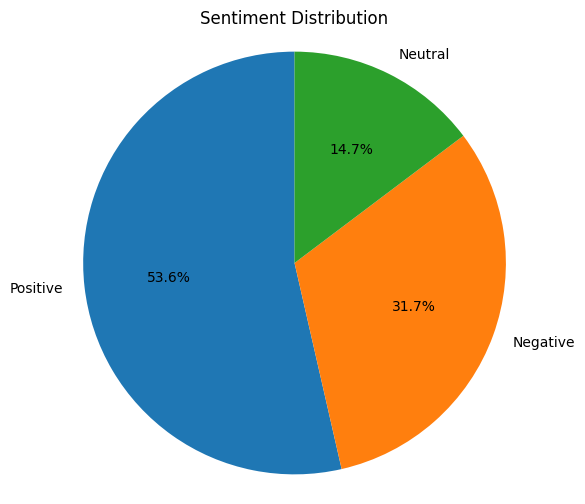

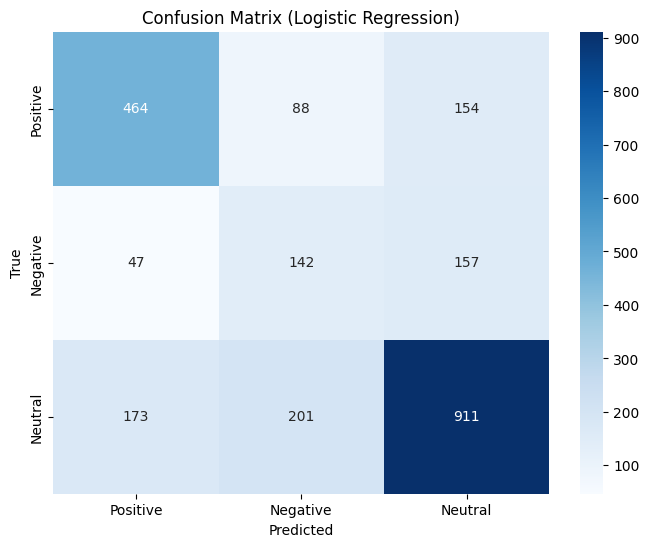

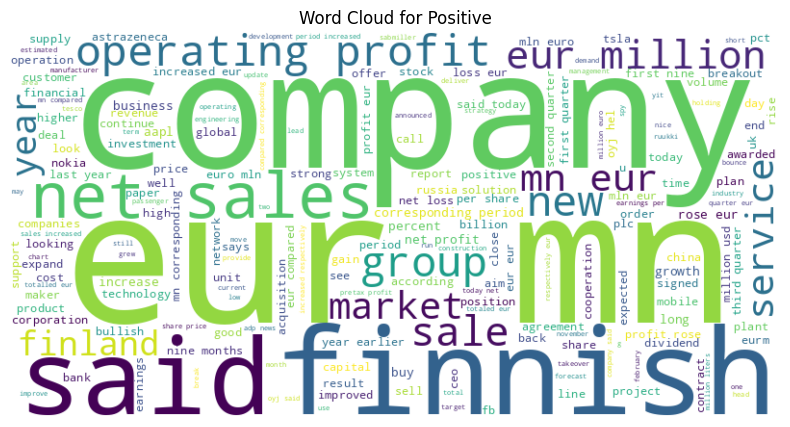

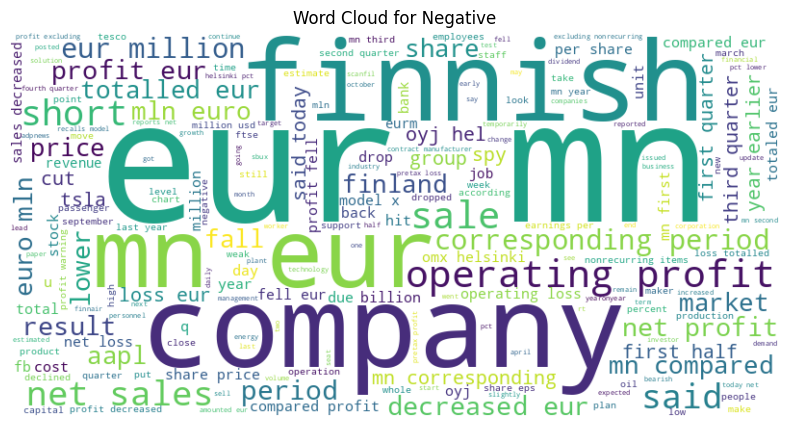

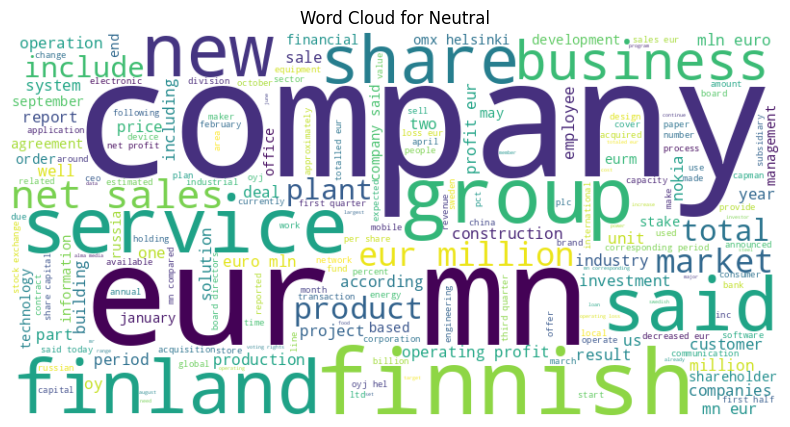

In [ ]:
#ประเมินผลโมเดล
def metrics(prediction, actual, model_name):
    print(f'\n=== {model_name} Performance ===')
    print('Confusion Matrix:\n', confusion_matrix(actual, prediction))
    print('Accuracy:', accuracy_score(actual, prediction))
    print('Precision:', precision_score(actual, prediction, average='weighted'))
    print('Recall:', recall_score(actual, prediction, average='weighted'))
    print('F1-score:', f1_score(actual, prediction, average='weighted'))
    print('\nClassification Report:\n', classification_report(actual, prediction))

# 1. โมเดล Multinomial Naive Bayes
clf_nb = MultinomialNB()
clf_nb.fit(xtrain_tfidf_res, ytrain_res)
prediction_nb = clf_nb.predict(xtest_tfidf)
metrics(prediction_nb, ytest, "Multinomial Naive Bayes")

# 2. โมเดล Logistic Regression ด้วย Grid Search
param_grid_lr = {'C': [0.1, 1, 10], 'max_iter': [1000]}
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5)
grid_lr.fit(xtrain_tfidf_res, ytrain_res)
print("Best parameters for Logistic Regression:", grid_lr.best_params_)
clf_lr = grid_lr.best_estimator_
prediction_lr = clf_lr.predict(xtest_tfidf)
metrics(prediction_lr, ytest, "Logistic Regression")

# 3. โมเดล Random Forest
clf_rf = RandomForestClassifier(random_state=42, n_estimators=100)
clf_rf.fit(xtrain_tfidf_res, ytrain_res)
prediction_rf = clf_rf.predict(xtest_tfidf)
metrics(prediction_rf, ytest, "Random Forest")

# การวิเคราะห์ข้อผิดพลาด (ใช้ Logistic Regression เป็นตัวอย่าง)
errors = xtest[prediction_lr != ytest].reset_index(drop=True)
true_labels = ytest[prediction_lr != ytest].reset_index(drop=True)
pred_labels = prediction_lr[prediction_lr != ytest]
print("\n=== Error Analysis (Top 5 Misclassifications) ===")
for i in range(min(5, len(errors))):
    print(f"Tweet: {errors[i]}")
    print(f"True Label: {true_labels[i]}, Predicted: {pred_labels[i]}\n")

# Visualization 1: Sentiment Distribution (Pie Chart)
label_counts = df['label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(label_counts.values, labels=['Positive', 'Negative', 'Neutral'], autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

# Visualization 2: Confusion Matrix Heatmap (ใช้ Logistic Regression)
cm = confusion_matrix(ytest, prediction_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

# Visualization 3: Word Cloud สำหรับแต่ละคลาส
for sentiment, label in zip(['Positive', 'Negative', 'Neutral'], [0, 1, 2]):
    text = ' '.join(df[df['label'] == label]['tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment}')
    plt.axis('off')
    plt.show()

In [ ]:
new_texts = [
    "The company is doing great this quarter!",
    "This stock is a complete disaster.",
    "Sales are stable, nothing special.",
    "BlackRock short BTC",
    "BTC to The Moon",
    "The Fed's preferred inflation gauge and tariff talk: What to know this week",
    "The biggest question facing the stock market"
]

In [ ]:
# ทำนายความรู้สึกของข้อความใหม่
new_texts_tfidf = vectorizer.transform(new_texts).toarray()
predictions_lr = clf_lr.predict(new_texts_tfidf)

# แสดงผลลัพธ์
for text, prediction in zip(new_texts, predictions_lr):
  if prediction == 0:
      sentiment = "Positive"
  elif prediction == 1:
      sentiment = "Negative"
  else:
      sentiment = "Neutral"

  print(f"Text: {text}")
  print(f"Predicted Sentiment: {sentiment}\n")


Text: The company is doing great this quarter!
Predicted Sentiment: Positive

Text: This stock is a complete disaster.
Predicted Sentiment: Positive

Text: Sales are stable, nothing special.
Predicted Sentiment: Neutral

Text: BlackRock short BTC
Predicted Sentiment: Negative

Text: BTC to The Moon
Predicted Sentiment: Negative

Text: The Fed's preferred inflation gauge and tariff talk: What to know this week
Predicted Sentiment: Neutral

Text: The biggest question facing the stock market
Predicted Sentiment: Positive

